# Maize Selection Trade-offs

Jupyter notebook describes ecohydrological nodel developed by Natasha Krell and Kelly Caylor to demonstrate crop water use and soil moisture balance of maize in central Kenya. The script below runs the model, simulates rainfall, outputs the results, and generates figures.

Last updated: 3 July 2019

## 1. Background
From Ridge to Reef notebook, Chapter 3.

### Tradeoffs between days to maturity and exposure to climate variability

This tradeoff is harder to quantify. Instead, we will model the interaction between days to maturity and crop failure. Our strategy will be to examine a very field-scale water balance that looks only at relative water availability \[mm/mm\], $s$, daily rainfall, $R$ \[mm/day\], and daily water demand, which we will characterize as reference evapotranspiration, $ET_0$ \[mm/day\]. Because temperature is relatively constant, we will assume that $ET_0$ is constant. Therefore our water balance is simply:


$$ \frac{dS}{dt} = R(t) - ET_0 $$

This formulation ignores many important processes related to soil water storage and plant response to drought. As defined, it is essentially a cumulative dryness index; during periods of the season when $\sum_t R(t) > t \times ET_0$, there will accumulation of water in the soil. During periods when $\sum_t R(t) < t \times ET_0$, the soil will dry out. 

Because the amount of plant available water in the soil in bounded between zero and some maximum, we add an additional parameter, $S_{max}$, which is the maximum amount of water `[mm]` that can be stored in the root zone. Now our model looks like this:

$$
\begin{eqnarray}
    \frac{dS}{dt} &=& R(t) - ET_0 & if & (0 \leq S \leq S_{max}) \\
    & & & else; \\
    \frac{dS}{dt} &=& 0 
\end{eqnarray}       
$$

Assuming a typical value of porosity is 0.4 and soil depth is 500 mm (0.5 meters), the value of $S_{max}$ is 200, here is what our model looks like in python:

```python
n = 0.4  # Porosity, [m3/m3]
Zr = 500 # Rooting depth [mm]
S_max = n*Zr    # Max soil water storage [mm]
S[0] = 30  # Initial soil water storage [mm]
ET_0 = 6.5 # Daily reference evapotranspiration [mm]

S = np.zeros(len(R)) # Pre-allocate the array for S
dSdt = np.zeros(len(R))# Pre-allocate the array for dSdt

for t in range(len(R)):
    dSdt[t] = R[t] - ET_0
    S[t+1] = S[t] + dSdt[t]
    if S[t+1] < S_max:
        S[t+1] = S_max
    if S[t+1] < 0:
        S[t+1] = 0
```

## 2. Import ecohydrology model

Model is saved as `runmodel.py` in folder. Evaporation and transpiration are seperated to calculate ET. Visualize preliminary figures. Export results and dataframes.

In [ ]:
%run runmodel.py

In [ ]:
calc_R(2,0.3,100,100)

In [55]:
runmodel()

,Value
0,1.866762
1,0.000000
2,0.000000
3,0.000000
4,0.000000


## 2. Simulatate rainfall totals

In [3]:
alpha=10
lambda_r = 0.3
t_seas = 120
n_seasons = 500
rainfall = np.array(calc_R(alpha, lambda_r, t_seas, n_seasons=500))

calc_R(10, 0.2, 120, 1)

array([[ 0.        ,  2.448699  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 29.91178969,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         9.32370169,  0.        ,  0.        ,  0.        , 38.56031352,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 13.14260595,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.20438371,
        31.01506095,  0.        ,  0.        ,  0.        ,  0.45509674,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.63507589,  0.        ,
        18.55933818,  0.        ,  9.00997809,  1.09276057, 25.11091267,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        16.64451957, 10.9444375 ,  0.        ,  6.9

(array([  1.,   9.,  24.,  70., 109., 123.,  81.,  55.,  20.,   8.]),
 array([104.52012177, 152.2060087 , 199.89189563, 247.57778257,
        295.2636695 , 342.94955643, 390.63544336, 438.32133029,
        486.00721723, 533.69310416, 581.37899109]),
 <a list of 10 Patch objects>)

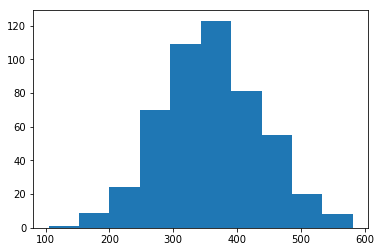

In [4]:
plt.hist(rainfall.sum(1))

### Non-stationarity

Adding non-stationary in "yearly alphas". Not sure where this should go. Perhaps in function with figures.
Previous = 500 realizations, not necessarily 500 years. Now: how to vary for multiple years.

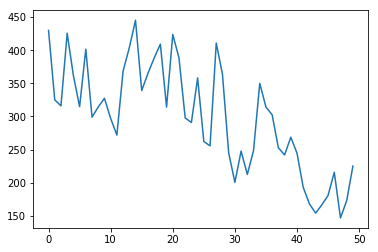

In [4]:
lambda_start = 0.3
lambda_end = 0.2
lambda_values = np.linspace(lambda_start, lambda_end, num=50)
rainfall = np.array([calc_R(alpha, lambda_r, t_seas) for lambda_r in lambda_values])
plt.plot(rainfall.sum(2))

### Code from Ridge to Reef Chapter 2

Using a $\lambda_r$ value of <code>0.40</code>, and assuming that the length of a growing season, $T_{seas}$, is 100 days, simulate a season of rainfall "events", where the value of a day is <code>1</code> if rainfall occurs, and <code>0</code> if not.

In [8]:
T_seas = 100 # Days in each season
N_seas = 100 # Number of seasons to simulate
alpha = 11
s_mat = np.random.uniform(low=0, high=1, size=[N_seas, T_seas])
amounts = np.random.exponential(scale=alpha, size=[N_seas, T_seas])

lam = 0.4 # Lambda value
rain_days = np.array(s_mat <= lam).astype(int)
rain = rain_days * amounts
rain.sum(axis=1).std()/rain.sum(axis=1).mean() # Analytical equation for this!

# Remains to be done: Need to include _seasonal_ variation in lambda and maybe(?) alpha.

0.23837175153932016

### Prepare historical rainfall using CETRAD dataset

In [15]:
from datetime import datetime
from dateutil.relativedelta import *

df = pd.read_csv("../data/CETRAD/CETRAD_rainfall.csv")  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

In [16]:
df.head()
df.tail()
station_list = [station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']]
print(station_list)

['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM', 'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN', 'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN', 'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM', 'NYERI MOW', 'OL ARABEL FOREST STN

Determine mean annual rainfall for each station

In [ ]:
# Import cleaned, merged datasets

In [35]:
AnnualRainfall = pd.read_csv("../data/CETRAD/AnnualRainfall.csv")  # Read in the Annual Rainfall per station
AnnualRainfall

,Year,Station,Annual Rainfall
0,1934,ARCHERS POST,NaN
1,1935,ARCHERS POST,NaN
2,1936,ARCHERS POST,NaN
3,1937,ARCHERS POST,NaN
4,1938,ARCHERS POST,NaN
5,1939,ARCHERS POST,NaN
6,1940,ARCHERS POST,NaN
7,1941,ARCHERS POST,NaN
8,1942,ARCHERS POST,NaN
9,1943,ARCHERS POST,NaN


In [30]:
md = pd.read_csv("../data/CETRAD/CETRADMetadata.csv")  # Read in the each stations metadata
md.head()

,Station Name,Annual Mean Rainfall,Annual SD Rainfall,UTM_x,UTM_y,Note
0,ARCHERS POST,355.741667,154.381690,351624.283,70807.012,NaN
1,ARDENCAPLE FARM,636.740616,226.335232,306006.828,9696.368,NaN
2,CASTLE FOREST STN,2033.627234,555.552122,311885.880,-44864.115,NaN
3,CHOGORIA FOREST STN,2225.510714,609.475564,343375.885,-26140.191,NaN
4,CHUKA FOREST STN,1915.845556,453.113081,344923.385,-34827.829,NaN


In [31]:
md.describe()

,Annual Mean Rainfall,Annual SD Rainfall,UTM_x,UTM_y
count,80.000000,80.000000,73.000000,73.000000
mean,846.456388,266.458853,280887.682932,4756.057425
std,366.869672,112.407249,38238.917088,33358.966855
min,355.557143,133.459860,194353.309000,-76827.970000
25%,636.573837,202.299506,263186.069000,-18075.287000
50%,725.021815,234.455798,284539.729000,4286.224000
75%,931.166310,291.891554,306006.828000,23732.173000
max,2225.510714,627.262341,351624.283000,122312.890000


In [34]:
# Return min, max, med:
md.sort_values(by='Annual Mean Rainfall')

# stations to use:
# L: OL JOGI FARM: 1967-1999, 32 years
# M: Kisima Farm
# H: Timau Marania: 1951-2015, # 64 years

,Station Name,Annual Mean Rainfall,Annual SD Rainfall,UTM_x,UTM_y,Note
39,MUKOGODO (NRM),355.557143,179.420270,284539.729,42749.591,NaN
0,ARCHERS POST,355.741667,154.381690,351624.283,70807.012,NaN
16,JUNCTION (EWASO NAROK),446.788571,192.403063,260384.335,56118.819,NaN
5,COLCHECCIO,450.030011,178.837883,255409.160,68804.307,NaN
6,DOL DOL DAO,518.613513,215.823611,295573.860,43649.450,NaN
58,OL JOGI FARM,538.010606,218.338311,270990.540,34572.776,NaN
36,MPALA FARM,539.928095,218.140679,266641.229,36040.935,NaN
31,MARALAL DC,549.508333,271.428898,244619.875,122312.890,NaN
63,PYRAMID OL JOGI,551.840000,217.756419,NaN,NaN,google earth?
29,LOLMARIK FARM,558.912195,216.602846,307781.793,11497.237,NaN


### Step 1. Filter data

In [12]:
station = 'ARDENCAPLE FARM' # 67 years of data
#station = 'JACOBSON FARM'
#station = 'EMBORI FARM'
columns = [station] + ['Year', 'Month', 'Datetime']
rainfall = df[columns]
rainfall.head()

,ARDENCAPLE FARM,Year,Month,Datetime
Datetime,,,,
1934-01-01,NaN,1934,1,1934-01-01
1934-01-02,NaN,1934,1,1934-01-02
1934-01-03,NaN,1934,1,1934-01-03
1934-01-04,NaN,1934,1,1934-01-04
1934-01-05,NaN,1934,1,1934-01-05


Check out the data

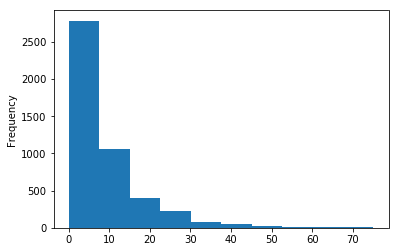

In [13]:
# Plot a histogram of rainfall values for days with rain.
daily_rainfall = rainfall.loc[rainfall[station] > 0][station]
daily_rainfall.plot.hist()

This looks okay, but we need to check and see how well the values in `daily_rainfall` fit our assumption of an exponential distribution.

### Step 2. Fit the distribution

To fit the distribution, we are going to use some more functions from `python`'s suite of numerical analysis. In this case we are going to use some functions from `scipy`. The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module has a large suite of distribution functions pre-defined, which we can use to develop a fit for our data. Using any of these distributions for fitting our data is very easy. The distribution we are most interested in is the exponential distribution, which is called `expon` in the `stats` module.

In [14]:
import scipy.stats as st

distribution = st.expon
data = daily_rainfall
params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

print(params)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

(0.09999998, 8.66751280486661)


### Step 3. Calculate fitted PDF and error with fit in distribution

To test the fit of our distribution, we can compare the empirical histogram to that predicted by our model. To do this, we first use our `data` to generate the empirical histogram. In this exampkle, we break the data into `30` bins, and we generate a histrogram of `density` rather than counts. This allows for an easier comparison between our empirical data and the fitted probability distribution function. Here are the steps:

1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
2. Shift the `x` bin locations generated from the histogram to the center of bins.
3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according to:

$$ SS_{error} = \sum_{i=1}^{n} \left(y_i - f(x_i)\right)^2 $$
$$ SS_{yy} = \sum_{i=1}^{n} \left(y_i - \bar{y}\right)^2 $$

5. Calculate the $r^2$ of the fit, according to

$$ r^2 = 1- \frac{SS_{error}}{SS_{yy}} $$ 

 

In [15]:
# Step 1. Generate a density histogram of the data 
y, x = np.histogram(data, bins=30, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )
print(r_2)


0.9916402851766069


This is an extremely good fit, so we can be confident that our assumption about an exponential distribution of rainfall is reasonable.

## Determining monthly values of  $\lambda_r$ 

We did something very similar to this in `Chapter 1`. Basically, we need to determine the probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month. For now, we assume stationarity in the monthly values, which means that we are assuming that the values of $\lambda_r$ in each month are the same through out the entire record (i.e. Jan 1938 has the same properties as Jan 2008). 

<div class="alert alert-info">💡 It's worth thinking about how you could test our stationarity assumption. If you have an idea of how to do so, go ahead and give it a shot!</div>

As a first step, let's get all the `rain_days` and all of the `observation_days` from the data on `JACOBSON FARM`. We will use method chaining to run a **groupby()** as we go.

In [16]:
# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0]

rain_days.head()

,ARDENCAPLE FARM,Year,Month,Datetime
Datetime,,,,
1948-02-11,2.5,1948,2,1948-02-11
1948-02-26,14.7,1948,2,1948-02-26
1948-03-03,6.3,1948,3,1948-03-03
1948-03-05,6.8,1948,3,1948-03-05
1948-03-09,13.9,1948,3,1948-03-09


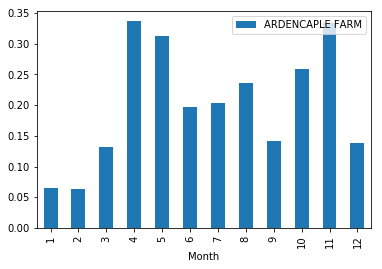

In [17]:
lambda_by_month = (
    rain_days.groupby('Month')[station].count() /
    all_days.groupby('Month')[station].count()
    )
pd.DataFrame(lambda_by_month).plot.bar()

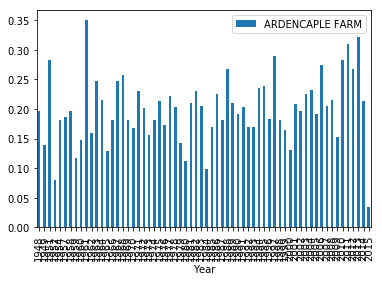

In [18]:
lambda_by_year = (
    rain_days.groupby('Year')[station].count() /
    all_days.groupby('Year')[station].count()
    )
pd.DataFrame(lambda_by_year).plot.bar()

## Simulating annual rainfall

To simulate annual rainfall, we are going to specify daily values of $\lambda_r$ using the monthly values we just calculated. The use of a variable $\lambda$ value in a poisson process creates what is known as an "inhomogenous poisson process" (or, alternatively, "nonhomogeneous"... unforatunetly, there isn't much homogeneity in what we call it!). These types of processes allow the properties of the process to change in space and time. Our implementation - using monthly values - is a little clunky, and we'd prefer to have the $\lambda$ values change more smoothly throughout the year. However, we probably don't have sufficient data to allow for this, even if we could accomodate the more complicated coding it would require. 

In order to generate our nonhomogenous process we will first generate a daily array of month numbers for the year `2018`. This is really easy in python using `datetime` + `timedelta` (which we need to import).

```python
    import datetime
    from datetime import timedelta
    datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
    month_value = np.array([datetime.month for datetime in datetimes])
```

In [19]:
from datetime import timedelta, datetime
datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

## To-Do #1
## turn this into dekad_value_by_day

In [20]:
print(lambda_by_month)

## To-Do #1
## turn this into lambda_by_dekad

## To-Do #2
## turn this into plot, and plot for each station 

Month
1     0.065020
2     0.064045
3     0.131660
4     0.337037
5     0.311828
6     0.196296
7     0.203789
8     0.236047
9     0.141270
10    0.258065
11    0.333333
12    0.138761
Name: ARDENCAPLE FARM, dtype: float64


In [59]:
print(month_value_by_day)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11

`numpy` makes it really easy to map the values in one array onto the values of another.

```python
    lambda_values = [lambda_by_month[i] for i in month_value_by_day]
```

In [21]:
lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])

With daily values of $\lambda_r$, we only need to follow the same cookbook we used to make the seasonal data:

```python
    alpha = scale  # Let's use the value we estimated from our exponential fit.
    simulated_rainfall_values = np.random.exponential(
        scale=alpha, size=len(lambda_values)) # Use the len() function instead of a constant.
```

    

In [22]:
alpha = scale

simulated_rainy_days = (np.random.uniform(low=0, high=1, size=len(lambda_values)) <= lambda_values).astype(int)
simulated_rainfall_values = np.random.exponential(scale=alpha, size=len(lambda_values))

simulated_rainfall = simulated_rainy_days * simulated_rainfall_values

## Plotting our simulated data

We can easily plot our rainfall data using the `datetimes` object we already created as the basis of our x-axis.

<BarContainer object of 364 artists>

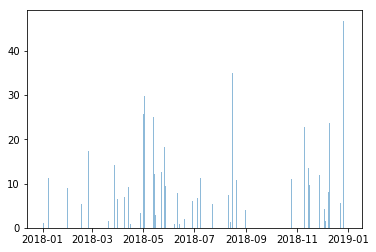

In [23]:
fig, ax = plt.subplots()

ax.bar(datetimes, simulated_rainfall, align='center', alpha=0.5)

<div class="alert alert-success">✏️ <strong>DIY Coding</strong>: Play around with our simulation. Here are a couple of ideas:</div>

1. Run 100 simulations of rainfall with our model for `JACOBSON FARM`. Compare the distribution of annual rainfall to the empirical distribution of annual rainfall.

2. Run the model for the same number of years that are in the `JACOBSON FARM` record and compare the mean and standard deviations of annual rainfall between the simulation and the empirical data. How well do they match?

2. Using the same simulations as in `2`, compare the mean and standard deviations of monthly rainfall between the simulation and the empirical data.

3. We've made $\lambda_r$ change every month, but we've used a constant $\alpha$ value. Determine if the assumption of a constant $\alpha$ is reasonable.

4. Determine the model parameters for a different station, preferably one with much lower or higher rainfall. How do the values of $\alpha$ and $\lambda_r$ change between stations?

5. Earlier I touched on the idea of non-stationarity in which the values of $\lambda_r$ and/or $\alpha$ may be changing over time. If you're up for it, see if you can come up with a way to investigate if our assumption of stationarity is valid.


## 3. Plotting

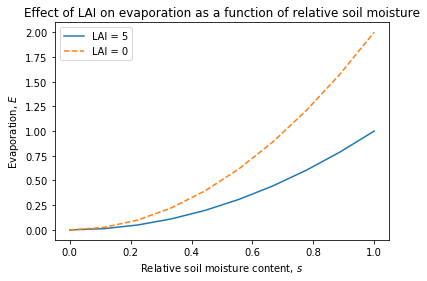

In [5]:
# Relationship between s and E
N = 10
y = np.zeros(N)
rs = np.linspace(0, 1, N, endpoint=True); rs

# Cacluate E_max before plotting calc_E
# Currently E_max is set as 1 and 2: need to fix.
calc_E_max(1,1)

# plot calc_E
plt.plot(rs, [calc_E(s,1) for s in rs], '-')
plt.plot(rs, [calc_E(s,2) for s in rs], '--')
plt.title('Effect of LAI on evaporation as a function of relative soil moisture')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
plt.ylabel('Evaporation, $\mathit{E}$')
plt.legend(['LAI = 5','LAI = 0'])
#plt.show()
#plt.axhline(y=2, color='black', linewidth=1.5)

#calc_E(4,1)

Text(0, 0.5, 'Transpiration, $\\mathit{T(s)}$')

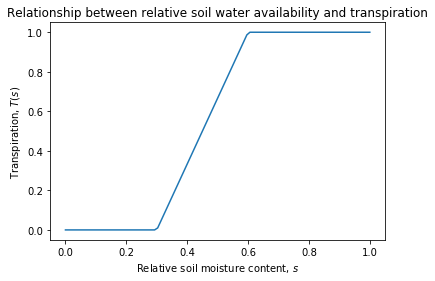

In [6]:
# Relationship between s and T
calc_T(0.1,1)

N = 100
y = np.zeros(N)
tr = np.linspace(0, 1, N, endpoint=True)

# Calculate T_max (which requires E_max) before plotting calc_T
plt.plot(tr, [calc_T(s,1) for s in tr], '-')
plt.title('Relationship between relative soil water availability and transpiration')
plt.xlabel('Relative soil moisture content, $\mathit{s}$')
plt.ylabel('Transpiration, $\mathit{T(s)}$')
#plt.show()

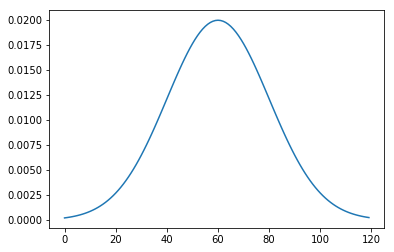

In [7]:
# Relationship between kc and DOY
N = 120
y = np.zeros(N)
yx = np.linspace(0, 120, N, endpoint=False)

plt.plot(yx, [calc_kc(x) for x in yx], '-')
#plt.show()

In [ ]:
# Relationship between kc and LAI

### Old code

In [237]:

# This is deleted

"""
def calc_single_season_R(alpha, lambda_r, t_seas):
    # Assume an exponential distribution of storm depth:
    amounts = np.random.exponential(scale=alpha, size=t_seas)
    
    # print('{lam} is not 1 and length {lam_len} is not {t_seas}'.format(
    #    lam=lambda_r,
    #    lam_len=len(lambda_r),
    #    t_seas=t_seas))

    if not is_instance(lambda_r, float):
        if len(lambda_r) != t_seas:
            raise ValueError("lamda_r values should be a constant, or have length of t_seas")
    
    rain_days = (np.random.uniform(low=0, high=1, size=t_seas) <= lambda_r).astype(int)
    return amounts * rain_days


def calc_multi_year_R(alpha, lambda_r, t_seas, n_seasons):
    rainfall = []
    for season in range(0,n_seasons):
        rainfall.append(calc_single_season_R(alpha, lambda_r, t_seas))
    return rainfall

"""


'\ndef calc_single_season_R(alpha, lambda_r, t_seas):\n    # Assume an exponential distribution of storm depth:\n    amounts = np.random.exponential(scale=alpha, size=t_seas)\n    \n    # print(\'{lam} is not 1 and length {lam_len} is not {t_seas}\'.format(\n    #    lam=lambda_r,\n    #    lam_len=len(lambda_r),\n    #    t_seas=t_seas))\n\n    if not is_instance(lambda_r, float):\n        if len(lambda_r) != t_seas:\n            raise ValueError("lamda_r values should be a constant, or have length of t_seas")\n    \n    rain_days = (np.random.uniform(low=0, high=1, size=t_seas) <= lambda_r).astype(int)\n    return amounts * rain_days\n\n\ndef calc_multi_year_R(alpha, lambda_r, t_seas, n_seasons):\n    rainfall = []\n    for season in range(0,n_seasons):\n        rainfall.append(calc_single_season_R(alpha, lambda_r, t_seas))\n    return rainfall\n\n'

In [ ]:
type(alpha)
a is float
len([a])
a = [1]
len(a)
len([a])
a = 2
len(a)